# Basic Shapes

In this module, you will familiarize yourself with the basics of persistence diagrams and the ripser library.  
* Bullet points indicate exercises to be performed by the student(s)

First, we perform all of the necessary library imports.  

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ripser import ripser, plot_dgms

We also setup some code that's used to do a "greedy permutation" or "furthest point sampling."  This will help us to evenly subsample a point cloud to reduce the computation time in certain cases while representing the geometry faithfully.

In [2]:
def getCSM(X, Y):
    """
    Return the Euclidean cross-similarity matrix between the M points
    in the Mxd matrix X and the N points in the Nxd matrix Y.
    :param X: An Mxd matrix holding the coordinates of M points
    :param Y: An Nxd matrix holding the coordinates of N points
    :return D: An MxN Euclidean cross-similarity matrix
    """
    C = np.sum(X**2, 1)[:, None] + np.sum(Y**2, 1)[None, :] - 2*X.dot(Y.T)
    C[C < 0] = 0
    return np.sqrt(C)

def getGreedyPerm(X, M, Verbose = False):
    """
    Purpose: Naive O(NM) algorithm to do the greedy permutation
    :param X: Nxd array of Euclidean points
    :param M: Number of points in returned permutation
    :returns: (permutation (N-length array of indices), \
            lambdas (N-length array of insertion radii))
    """
    #By default, takes the first point in the list to be the
    #first point in the permutation, but could be random
    perm = np.zeros(M, dtype=np.int64)
    lambdas = np.zeros(M)
    ds = getCSM(X[0, :][None, :], X).flatten()
    for i in range(1, M):
        idx = np.argmax(ds)
        perm[i] = idx
        lambdas[i] = ds[idx]
        ds = np.minimum(ds, getCSM(X[idx, :][None, :], X).flatten())
        if Verbose:
            interval = int(0.05*M)
            if i%interval == 0:
                print("Greedy perm %i%s done..."%(int(100.0*i/float(M)), "%"))
    Y = X[perm, :]
    return {'Y':Y, 'perm':perm, 'lambdas':lambdas}

## Example 1: Circles

As a first example, we will make a circle.  Once you understand this example, starting from the code below, see if you can modify the point cloud or come up with a new point cloud that does the following

* Increase the birth time of the H1 dot without changing the radius of the circle
* Decrease the birth time of the H1 dot without changing the radius of the circle
* What happens to H1 when you add a point that's at the center of the circle at position $(0, 0)$?
* Change the point cloud so that there are two 1D dots with large (>1) but different persistences

<IPython.core.display.Javascript object>


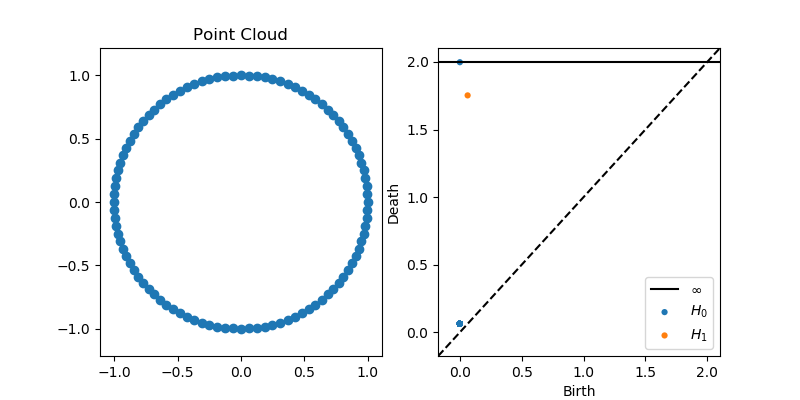

In [3]:
# Create 100 points on the unit circle
N = 100
t = np.linspace(0, 2*np.pi, N+1)[0:N]
X = np.zeros((N, 2))
X[:, 0] = np.cos(t)
X[:, 1] = np.sin(t)

# Compute the persistence diagram of this point cloud
dgms = ripser(X)['dgms']

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal')
plt.title("Point Cloud")
plt.subplot(122)
plot_dgms(dgms)
plt.show()


## Example 2: Stability of Bottleneck/Wasserstein Distances




## Example 3: Sphere And Projective Plane

We will now randomly sample some points on the two dimensional sphere and compute persistent homology up to dimension 2, using the <i>intrinsic metric</i>, which is the arc length between points.  A point $X = (x, y, z)$ is randomly drawn from a 3D gaussian distribution 

$(x, y, z) \~ \left(\frac{1}{2 \pi}\right)^{3/2} \exp{\left( - (x^2+y^2+z^2)/2 \right) }$

and normalized to have a length of 1 (<i>why does this evenly sample on the sphere?</i>)

Note that the arc length along a unit circle is equal to the angle subtending that circle in radians. Thus, given two unit vectors on the sphere $x_1$ and $x_2$, the arc length between them is $\cos^{-1}(x_1 \cdot x_2)$.  We will implement this in code below to compute all pairwwise arc lengths between our sampled points on the sphere.  We will then compute a rips filtration up to dimension 2.

* How many essential classes are in H1 and H2?  Does this match the homology of a sphere?


<IPython.core.display.Javascript object>


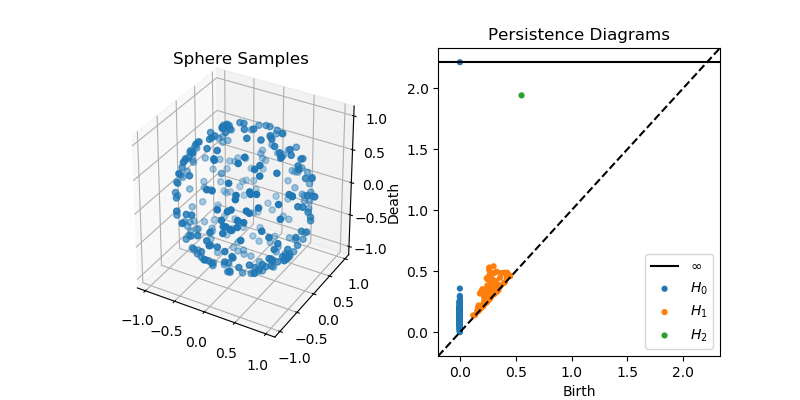

Text(0.5,1,'Persistence Diagrams')

In [4]:
# Step 1: Setup the point cloud
N = 300 #Number of points
X = np.random.randn(N, 3) #Draw from 3D Gaussian
X = X/np.sqrt(np.sum(X**2, 1))[:, None] #Normalize each point to unit length

# Step 2: Compute all pairwise arc lengths between sampled points
dotProds = X.dot(X.T) #Entry ij in this matrix holds the dot product between point i and j, or cos(theta)
#The dot products should be in [-1, 1], but may leave this range due to numerical roundoff
dotProds[dotProds < -1] = -1
dotProds[dotProds > 1] = 1
DSphere = np.arccos(dotProds) #The arc length is the inverse cosine of the dot products of unit vectors

dgms = ripser(DSphere, distance_matrix=True, maxdim=2)['dgms']
fig = plt.figure(figsize=(8, 4))
ax = plt.subplot(121, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2])
plt.title("Sphere Samples")
plt.subplot(122)
plot_dgms(dgms)
plt.title("Persistence Diagrams")

* Now see if you can perform a simple modification so that the sample points live on the projective plane $RP^2$ instead of the sphere; that is, re-compute the distances under the identification $x \~ -x$.

<b>Hint: The arc length between two points on the unit projective plane can never exceed $\pi/2$ radians.  As soon as the arc length goes past $\pi/2$, it starts to go back the other way</b>

* The code below will compute persistence diagrams with $\mathbb{Z} / 2$ coefficients and $\mathbb{Z} / 3$ coefficients.  Is there a change?  Why or why not?
* Switch back to there sphere distance and look at the results with  $\mathbb{Z} / 2$ coefficients and $\mathbb{Z} / 3$ coefficients.  Is there a change?  Why or why not?

<IPython.core.display.Javascript object>


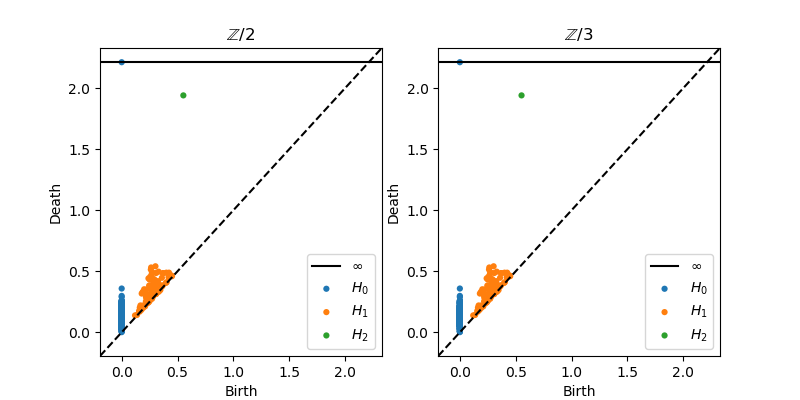

Text(0.5,1,'$\\mathbb{Z}/3$')

In [5]:
DRP2 = np.arccos(dotProds) #TODO: This line currently computes sphere distances; 
#update it so that it computes projective plane distances

dgmsz2 = ripser(DRP2, distance_matrix=True, maxdim=2)['dgms']
dgmsz3 = ripser(DRP2, distance_matrix=True, maxdim=2, coeff=3)['dgms']
plt.figure(figsize=(8, 4))
plt.subplot(121)
plot_dgms(dgmsz2)
plt.title("$\mathbb{Z}/2$")
plt.subplot(122)
plot_dgms(dgmsz3)
plt.title("$\mathbb{Z}/3$")


## Example 4: 3D Embedded Torus And Flat Torus

We will now sample points from a torus embedded in 3D and compute persistent homology up to H2.  Given a parameter $R$ whih is the radius of a circle through the center of the tube and a parameter $r$ which is the width of the tube, we use the following equation for the 3D coordinates of a point $(\theta, \phi)$, where $\theta$ is along the $r$ radius circle and $\phi$ is along the $R$ radius circle:

$x = (R + r \cos(\theta)) \cos (\phi)$

$y = (R + r \cos(\theta)) \sin (\phi)$

$z = r \sin (\theta)$

* What happens to the persistence diagram as you vary $R$ and $r$?


<IPython.core.display.Javascript object>


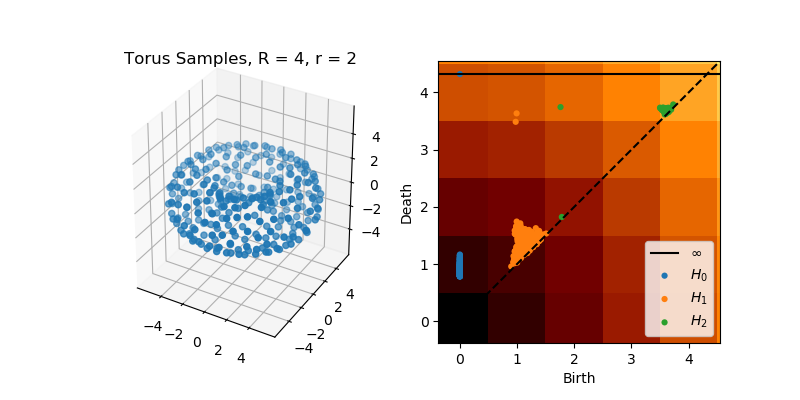

In [6]:
N = 10000 #Number of initial points in (theta, phi) space
NPoints = 300 #Number of points to evenly subsample in 3D
R = 4
r = 2
theta = np.random.rand(N)*2*np.pi
phi = np.random.rand(N)*2*np.pi
X = np.zeros((N, 3))
X[:, 0] = (R + r*np.cos(theta))*np.cos(phi)
X[:, 1] = (R + r*np.cos(theta))*np.sin(phi)
X[:, 2] = r*np.sin(theta)
# Evenly subsample the points geometrically
X = getGreedyPerm(X, NPoints)['Y']
xr = [np.min(X.flatten()), np.max(X.flatten())]

#Now compute persistence diagrams up to H2
dgms = ripser(X, maxdim=2)['dgms']

plt.figure(figsize=(8, 4))
ax = plt.subplot(121, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2])
ax.set_xlim(xr)
ax.set_ylim(xr)
ax.set_zlim(xr)
plt.title("Torus Samples, R = %g, r = %g"%(R, r))
plt.subplot(122)
plot_dgms(dgms)
plt.show()

Now we will sample points from a "flat torus."  The domain is $[0, 1] \times [0, 1]$, with $(x, 0)$ identified with $(x, 1)$ and $(0, y)$ identified with $(1, y)$.  The metric is simply the flat planar Euclidean metric

* Fill in the code below in the function <b>get_flat_torus_dists</b>, which computes all pairwise distances of points on a flat torus.  Right now, the code simply computes the Euclidean distance between points without any identifications.

<b>Hint: You may need to use the function <u>np.minimum</u></b>

In [23]:
def get_flat_torus_dists(x, y):
    """
    Compute all pairwise distances on the flat torus [0, 1] x [0, 1]
    
    Parameters:
    x : ndarray (N)
        An N-length list of x coordinates of each point
    y : ndarray (N)
        An N-length list of y coordinates of each point
    
    Returns:
    D : ndarray (N, N)
        A distance matrix whose ijth entry is the distance along the flat torus between (x[i], y[i]) and (x[j], y[j])
    """
    
    dx = np.abs(x[:, None] - x[None, :])
    dy = np.abs(y[:, None] - y[None, :])
    
    ##TODO: FINISH THIS AND MAKE IDENTIFICATIONS
    dx = np.minimum(dx, np.abs(x[:, None] - (x[None, :] - 1)))
    dx = np.minimum(dx, np.abs(x[:, None] - (x[None, :] + 1)))
    dy = np.minimum(dy, np.abs(y[:, None] - (y[None, :] - 1)))
    dy = np.minimum(dy, np.abs(y[:, None] - (y[None, :] + 1)))
    ##
    
    return np.sqrt(dx**2 + dy**2)
    

Now use your function to compute a distance matrix, run ripser, and verify that you get the correct signature for a torus

<IPython.core.display.Javascript object>


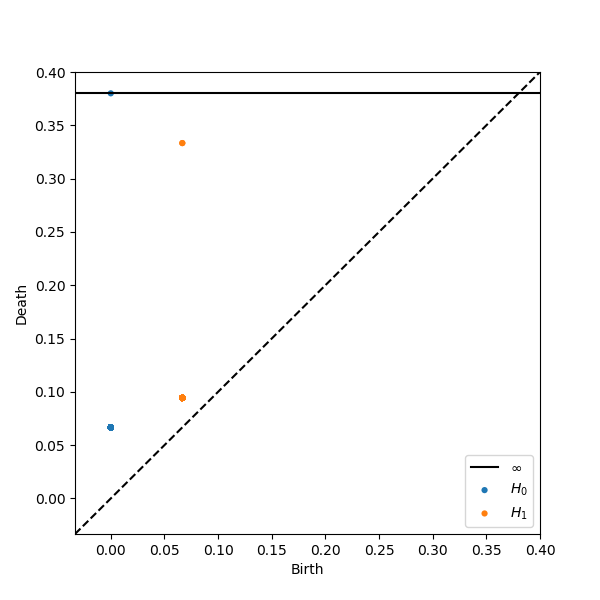

In [24]:
res = 15 #Number of points along each dimension
grid = np.linspace(0, 1, res+1)[0:res]
x, y = np.meshgrid(grid, grid)
x = x.flatten()
y = y.flatten()

D = get_flat_torus_dists(x, y)

#D = D[0, :]
#D = np.reshape(D, (res, res))

plt.figure(figsize=(6, 6))
dgms = ripser(D, distance_matrix=True, maxdim=1)['dgms']
plot_dgms(dgms)
plt.show()
